In [5]:
import sys
import datetime

import numpy as np
from scipy import integrate
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from struct import pack, unpack

sys.path.insert(0, "../")
from paths import FIG_DIR, DATA_DIR

# Small m

In [12]:
def compute_lcs_volume_vectorized(p_matr, ssb):
    normal = - p_matr @ ssb
    normal_short = np.where(normal < 0, normal, 0)
    with np.errstate(divide='ignore'):
        factors = normal_short[:, :, None] / (normal_short[:, :, None] - normal[:, None, :])
        factors = np.nan_to_num(factors, copy=False, nan=1.0, posinf=1.0, neginf=1.0)
    summands = np.prod(factors, axis=2)
    return np.sum(summands, axis=1)

In [13]:
# intr_dict = {4: 0.0013068658490566038, 5: 0.0023164428679245284} # compare Notebook 5_2 and 5_3
# with open(DATA_DIR / '5_4_sim_transitive.dat', 'wb') as file:
#     file.write(pack('d' * len(intr_dict) , *intr_dict.values()))

In [14]:
num_samples = 2.65 * 10**10 #1 sample corresponds to 3 lotteries, a triple!

with open(DATA_DIR / '5_4_sim_transitive.dat', 'rb') as file:
    packed = file.read()
    read = list(unpack('d' * (len(packed) // 8), packed)) # 8 bytes per double
intr_dict = {i + 4: read[i] for i in range(len(read))}

for m in range(4 + len(intr_dict), 16):
    now = datetime.datetime.now()
    print(f"Starting {m} at {now.strftime('%Y-%m-%d %H:%M:%S')}")

    rng = np.random.default_rng(2025 + m)
    ssb_tr = np.triu(np.ones((m, m))) - np.tril(np.ones((m, m)))
    alpha = np.ones(m)
    batch_size = 10**7

    batch_results = []

    for i in range(len(batch_results)*batch_size, int(num_samples), batch_size):
        lotteries = rng.dirichlet(alpha, (3, batch_size))
        comp01 = (np.sum(lotteries[0,:,:] @ ssb_tr * lotteries[1,:,:], axis=1) > 0).astype(int)
        comp12 = (np.sum(lotteries[1,:,:] @ ssb_tr * lotteries[2,:,:], axis=1) > 0).astype(int)
        comp20 = (np.sum(lotteries[2,:,:] @ ssb_tr * lotteries[0,:,:], axis=1) > 0).astype(int)
        num_intr = np.sum(comp01 + comp12 + comp20 == 0) + np.sum(comp01 + comp12 + comp20 == 3)
        batch_results.append(num_intr/batch_size)

    now = datetime.datetime.now()
    print(f"Finished {m} at {now.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Results for m={m}: np.mean(batch_results)={np.mean(batch_results)}, np.std(batch_results)={np.std(batch_results)}, len(batch_results)={len(batch_results)}")
    intr_dict[m] = np.mean(batch_results)
    with open(DATA_DIR / '5_4_sim_transitive.dat', 'wb') as file:
        file.write(pack('d' * len(intr_dict) , *intr_dict.values()))

In [15]:
with open(DATA_DIR / '5_4_sim_transitive.dat', 'rb') as file:
    packed = file.read()
    read = list(unpack('d' * (len(packed) // 8), packed)) # 8 bytes per double
intr_dict = {i + 4: read[i] for i in range(len(read))}
intr_dict[3] = 0
intr_dict

{4: 0.0013068658490566038,
 5: 0.0023164428679245284,
 6: 0.0029405492452830194,
 7: 0.0032902126037735848,
 8: 0.003469022490566038,
 9: 0.003539500716981132,
 10: 0.0035421367924528303,
 11: 0.0035046867169811315,
 12: 0.003442786603773585,
 13: 0.0033663879622641505,
 14: 0.003281799886792453,
 15: 0.0031939550188679246,
 3: 0}

In [16]:
df = pd.DataFrame(intr_dict.items(), columns=["num_alt", "prob_intr"])
df['error'] = 1e-5
df.loc[df['num_alt'] == 3, 'error'] = 0
df

,num_alt,prob_intr,error
0,4,0.001307,0.00001
1,5,0.002316,0.00001
2,6,0.002941,0.00001
3,7,0.003290,0.00001
4,8,0.003469,0.00001
5,9,0.003540,0.00001
6,10,0.003542,0.00001
7,11,0.003505,0.00001
8,12,0.003443,0.00001
9,13,0.003366,0.00001


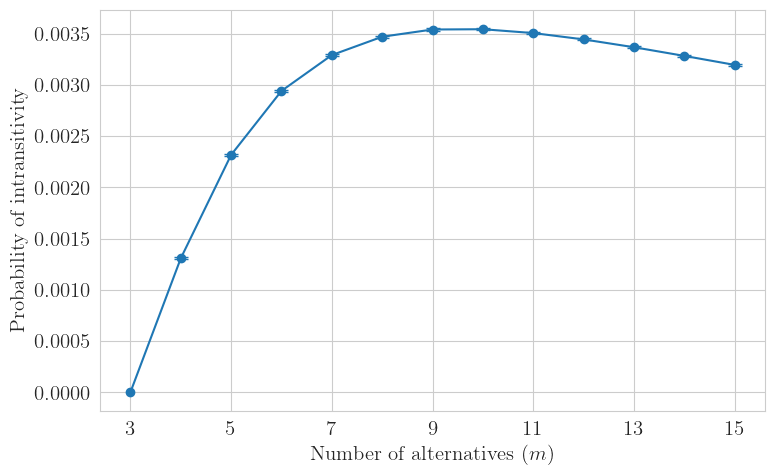

In [17]:
sns.set_style(style="whitegrid")
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'cm'
mpl.rcParams['font.size'] = 15

# Plot with error bars
plt.figure(figsize=(8, 5))
line = sns.lineplot(x='num_alt', y='prob_intr', data=df, err_style='bars', errorbar=None)
plt.errorbar(df[df['num_alt'] > 3]['num_alt'], df[df['num_alt'] > 3]['prob_intr'], yerr=df[df['num_alt'] > 3]['error'], fmt='o', color=line.lines[0].get_color(), capsize=5)
plt.scatter(3, 0, color=line.lines[0].get_color())

# Set x-axis ticks to show only odd numbers
plt.xticks(ticks=df['num_alt'][df['num_alt'] % 2 == 1])

# Modify axis labels
plt.xlabel(r'Number of alternatives ($m$)')
plt.ylabel("Probability of intransitivity")

plt.tight_layout()
plt.savefig(FIG_DIR / "5_4_sim_tr_low_m.png", dpi=300)
plt.savefig(FIG_DIR / "5_4_sim_tr_low_m.pdf")

# Large m

In [2]:
import numpy as np

num_rep = 10**5  # executed 10 times
rng = np.random.default_rng(2525)
results = {}

for m in [5, 10, 15, 20, 30, 50, 70, 100, 150, 200, 300, 400, 600, 800, 1000]:
    results[m] = []
    ssb_utility = np.triu(np.ones((m, m))) - np.tril(np.ones((m, m)))
    alpha = np.ones(m)
    for _ in range(10):
        lotteries = rng.dirichlet(alpha, (3, num_rep))
        comp01 = (np.sum(lotteries[0,:,:] @ ssb_utility * lotteries[1,:,:], axis=1) > 0).astype(int)
        comp12 = (np.sum(lotteries[1,:,:] @ ssb_utility * lotteries[2,:,:], axis=1) > 0).astype(int)
        comp20 = (np.sum(lotteries[2,:,:] @ ssb_utility * lotteries[0,:,:], axis=1) > 0).astype(int)
        num_intr = np.sum(comp01 + comp12 + comp20 == 0) + np.sum(comp01 + comp12 + comp20 == 3)
        results[m].append(num_intr)
    print(f"Completed m = {m}")

Completed m = 5
Completed m = 10
Completed m = 15
Completed m = 20
Completed m = 30
Completed m = 50
Completed m = 70
Completed m = 100
Completed m = 150
Completed m = 200
Completed m = 300
Completed m = 400
Completed m = 600
Completed m = 800
Completed m = 1000


In [8]:
import pickle 

# with open(DATA_DIR / '5_4_sim_tr_large_m.pkl', 'wb') as f:
#     pickle.dump(results, f)
        
with open(DATA_DIR / '5_4_sim_tr_large_m.pkl', 'rb') as f:
    results = pickle.load(f)

results

{5: [221, 268, 239, 232, 216, 224, 229, 216, 243, 240],
 10: [397, 329, 332, 351, 347, 349, 340, 359, 346, 337],
 15: [333, 307, 314, 341, 295, 307, 307, 294, 345, 319],
 20: [271, 306, 282, 269, 269, 262, 259, 294, 294, 278],
 30: [236, 214, 213, 241, 192, 229, 213, 231, 200, 207],
 50: [134, 145, 132, 124, 141, 143, 140, 178, 144, 125],
 70: [102, 107, 114, 108, 93, 122, 97, 102, 101, 115],
 100: [72, 75, 69, 90, 78, 56, 80, 67, 81, 97],
 150: [55, 55, 44, 59, 51, 48, 60, 56, 59, 47],
 200: [38, 33, 37, 37, 37, 29, 41, 31, 25, 30],
 300: [23, 23, 36, 35, 20, 28, 31, 19, 26, 22],
 400: [19, 14, 13, 19, 16, 19, 17, 25, 17, 29],
 600: [19, 16, 16, 12, 17, 16, 15, 13, 20, 15],
 800: [12, 8, 11, 12, 10, 16, 10, 7, 9, 12],
 1000: [11, 11, 10, 11, 8, 8, 9, 9, 5, 8]}

In [18]:
plotting_dict = {}

for key, value in results.items():
    plotting_dict[key] = np.mean(value) / num_rep

df = pd.DataFrame(plotting_dict.items(), columns=["num_alt", "prob_intr"])
df

,num_alt,prob_intr
0,5,0.002328
1,10,0.003487
2,15,0.003162
3,20,0.002784
4,30,0.002176
5,50,0.001406
6,70,0.001061
7,100,0.000765
8,150,0.000534
9,200,0.000338


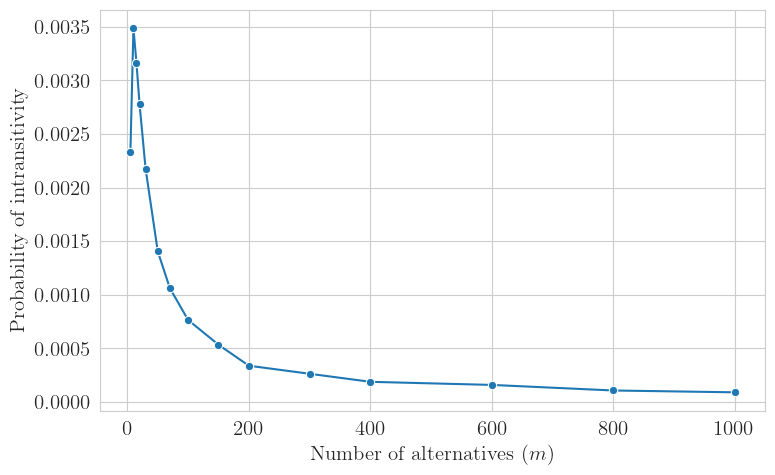

In [19]:
sns.set_style(style="whitegrid")
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'cm'
mpl.rcParams['font.size'] = 15

# Plot with error bars
plt.figure(figsize=(8, 5))
line = sns.lineplot(x='num_alt', y='prob_intr', data=df, err_style='bars', errorbar=None, marker='o')

# Modify axis labels
plt.xlabel(r'Number of alternatives ($m$)')
plt.ylabel("Probability of intransitivity")

plt.tight_layout()
plt.savefig(FIG_DIR / "5_4_sim_tr_high_m.png", dpi=300)
plt.savefig(FIG_DIR / "5_4_sim_tr_high_m.pdf")